# Testing Scene Modeling for Curveball Integration

## Object DC21cyddn

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import subprocess

import config
import subtract
import db
from exposuresource import ExposureSource
from processing import cat_psf_sky
from psfexreader import PSFExReader
from sexsky import sexsky

import scarlet, scarlet2
from scarlet2 import *
from numpyro.distributions import constraints
import numpyro.distributions as dist
from astropy.io import fits
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
from astropy.nddata import Cutout2D
import optax
import uuid
import glob
import sep
import astropy.units as u

import jax.numpy as jnp
from scarlet.display import AsinhMapping,AsinhPercentileNorm
from scarlet.display import show_scarlet2_scene,LinearPercentileNorm

import mystuff

/usr/local/lib/python3.10/dist-packages/equinox/_module.py:257: UserWarning: Class `scarlet2.morphology.ArrayMorphology` has both an `__init__` method and a `__post_init__` method. This means that the `__post_init__` method will not be run!
The reason for this is that `__post_init__` is intended to be used with the automatically-generated `__init__` method provided by Python dataclasses, which are generated of the form:
```
def __init__(self, field1, field2)
    self.field1 = field1
    self.field2 = field2
    self.__post_init__()
```
and as such a user-provided `__init__` overrides both the setting of fields, and the calling of `__post_init__`.
The above is how Python dataclasses work, and has nothing to do with Equinox!
If you are using `__post_init__` to check that certain invariants hold, then consider using `__check_init__` instead. This is an Equinox-specific extension that is always ran. See here for more details: https://docs.kidger.site/equinox/api/module/advanced_fields/#che

In [2]:
obj_name = 'DC21cozcn'
peakt = 59519
data_dir = os.path.expandvars(f"$SCRATCH/data/saved_curveball/test_scarlet/{obj_name}")
if not os.path.exists(data_dir):
    os.mkdir(data_dir)
print(data_dir)
config.Config.init('emily_saul.yaml')
decam = ExposureSource.get("DECam/Reduced")

obj = db.Object.get_by_name(obj_name)
img_objs = db.Image.get_including_point(obj.ra, obj.dec)
mjds = np.array([x.mjd for x in img_objs if 'stack' not in x.basename])
idxs = np.argsort(mjds)
basenames = np.array([x.basename for x in img_objs if 'stack' not in x.basename])
basenames = basenames[idxs]
basenames = basenames[[1, 2, 100, 150, 200, 250, 300, 350, -20, -1]] # Comment out if you want the full LC
# basenames = basenames[(mjds>peakt-120)&(mjds<peakt+90)] # Comment this line if you want the full LC
# basenames = basenames[::4] # Comment this line if you want the full lightcurve

imagelist = [decam.local_path_from_basename(x) for x in basenames]
masklist = [decam.local_path_from_basename(x, filetype='mask') for x in basenames]
weightlist = [decam.local_path_from_basename(x, filetype='weight') for x in basenames]
print(f"{len(imagelist)} images")

tmpdir = f'/tmp/{uuid.uuid4().hex}'

ra = obj.ra
dec = obj.dec

sc = SkyCoord( obj.ra, obj.dec, frame='icrs', unit=u.deg )
coord_transient = SkyCoord(ra*u.deg, dec*u.deg, frame='icrs')

/pscratch/sd/e/eramey16/data/saved_curveball/test_scarlet/DC21cozcn
10 images


In [3]:
with fits.open(imagelist[0]) as hdul:
    hdr = hdul[0].header
    wcs = WCS(hdul[0].header)
    print(wcs.world_to_pixel( sc ))
# hdr

(array(530.42459199), array(2225.33661103))


In [4]:
# # Create coadd.head file for swarp
# # This aligns all images to the first one
# coadd_path = f'{data_dir}/coadd.head'
# with fits.open(imagelist[0]) as hdul:
#     wcs = WCS(hdul[0].header)

# if os.path.exists(coadd_path):
#     raise ValueError("coadd.head already exists, delete before continuing")

# new_header = wcs.to_header()
# newhdu = fits.PrimaryHDU(header=new_header)
# newhdu.writeto(coadd_path)

In [5]:
trim = [100,100]
tiny=1e-10
hdrkeywords = decam.key_keywords
resample_dir = data_dir
swarpcmd = ( f'swarp -SUBTRACT_BACK N '
             f'-COMBINE N -MEM_MAX 2048 '
             f'-CELESTIAL_TYPE NATIVE '
             f'-PROJECTION_TYPE TAN '
             f'-RESAMPLING_TYPE BILINEAR '
             # f'-CENTER_TYPE MANUAL -CENTER {centerra},{centerdec} '
             # f'-IMAGE_SIZE {trim[0]},{trim[1]} '
             f'-NTHREADS 0 -RESAMPLE_DIR {resample_dir} -VMEM_DIR {tmpdir} '
             # f'-WEIGHT_IMAGE {",".join([str(s) for s in weightlist])} '
             # f'-WEIGHT_TYPE MAP_WEIGHT -WEIGHT_THRESH {tiny} '
             f'-RESCALE_WEIGHTS Y '
             f'-WRITE_FILEINFO Y '
             f'-VERBOSE_TYPE LOG '
             f'-DELETE_TMPFILES N '
             f'-COPY_KEYWORDS {hdrkeywords},SEEING '
             f'{" ".join([str(i) for i in imagelist])}' )
# subprocess.run(swarpcmd.split(), shell=False)

In [6]:
resamp = [f'{data_dir}/{x}.resamp.fits' for x in basenames]
resamp_weights = [f"{data_dir}/{x}.resamp.weight.fits" for x in basenames]
resamp_masks = [f"{data_dir}/{x}.resamp.mask.fits" for x in basenames]
resamp_cats = [f"{data_dir}/{x}.resamp.cat" for x in basenames]
resamp_psfs = [f"{data_dir}/{x}.resamp.psf" for x in basenames]

clip_files = [f"{data_dir}/{x}.clip.fits" for x in basenames]
clip_weight_files = [f"{data_dir}/{x}.clip.weight.fits" for x in basenames]
clip_mask_files = [f"{data_dir}/{x}.clip.mask.fits" for x in basenames]

In [7]:
# for file in resamp+resamp_weights+resamp_masks+resamp_cats+resamp_psfs:
#     if os.path.exists(file):
#         os.remove(file)

In [8]:
with fits.open(imagelist[0]) as hdul:
    wcs = WCS(hdul[0].header)
    hdr = hdul[0].header
    print(wcs.world_to_pixel( sc ))
wcs

(array(530.42459199), array(2225.33661103))


WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : 7.873438464982 -43.01064858422 
CRPIX : 4404.6 -8601.334 
CD1_1 CD1_2  : -1.259570882481e-07 7.287951039532e-05 
CD2_1 CD2_2  : -7.286550531521e-05 -1.50717451845e-07 
NAXIS : 2046  4094

In [9]:
def makeCatalog(observations, lvl=3, wave=True):
    normed_images = np.asarray([obs.data for obs in observations])
    interps = [scarlet.interpolation.interpolate_observation(obs, observations[0]) for obs in obssingle]
    interps = np.asarray(interps/np.sum(interps))
    detect_image = np.sum(interps,axis=(0,1))
    # Wavelet transform
    wave_detect = scarlet.Starlet.from_image(detect_image).coefficients

    if wave:
        # Creates detection from the first 3 wavelet levels
        detect = wave_detect[:lvl,:,:].sum(axis = 0)
    else:
        detect = detect_image

        # Runs SEP detection
    bkg = sep.Background(detect)
    catalog = sep.extract(detect-bkg.globalback, 6, err=bkg.globalrms)
    background=[]
    bg_rms=[]
    for obs in observations:
        img = obs.data
        if np.size(img.shape) == 3:
            bg_rms.append(np.array([sep.Background(band).globalrms for band in img]))
            background.append(np.array([sep.Background(band).globalback for band in img]))
        else:
            bg_rms.append(sep.Background(img).globalrms)
            background.append(sep.Background(img).globalback)
    return catalog, bg_rms, detect_image, background

Update 'python run_cat.py' and run it in a terminal

In [10]:
clips = []
clipwts = []
clipmasks = []
clipwcs = []
clippsfs = []
ra_dec = []
zps = []
clipbgs = []
tiny=1e-5

# ra_dec = [sc]

for i,img in enumerate(resamp):
    
    # # Get subtraction file paths
    # path = decam.local_path(img)
    # weightpath = decam.local_path(imgweights[i])
    # maskpath = decam.local_path(imgmasks[i])
    if not os.path.exists(img):
        clips.append(None)
        clipwts.append(None)
        clipmasks.append(None)
        clippsfs.append(None)
        zps.append(None)
        continue
    
    with fits.open(img) as file:
        imgwcs = WCS(file[0].header)
        x, y = imgwcs.world_to_pixel(sc)
    
    # Get resampled PSF at image scale
    try:
        psf_file = resamp_psfs[i]
        reader = PSFExReader(psf_file)
        psf = reader.getclip(x, y, flux=1)
        clippsfs.append(psf)
        print(psf.shape)
    except Exception as e:
        print(f"\nFile {psf_file}:\n{e}\n")
        clips.append(None)
        clipwts.append(None)
        clipmasks.append(None)
        clippsfs.append(None)
        zps.append(None)
        continue
    
    if os.path.exists(clip_files[i]):
        with fits.open(clip_files[i]) as hdul:
            clips.append(hdul[0].data)
            _clipwcs = WCS(hdul[0].header)
            zps.append(hdul[0].header['MAGZERO'])
        with fits.open(clip_weight_files[i]) as hdul:
            clipwts.append(hdul[0].data)
        with fits.open(clip_mask_files[i]) as hdul:
            clipmasks.append(hdul[0].data)
    else:
        raise ValueError("Uncomment this")
    
    clipwcs.append(_clipwcs)
#         with fits.open( img, memmap=True ) as hdul:
#             # Get WCS from header of sub file
#             wcs = WCS(hdul[0].header)
#             zps.append(hdul[0].header['MAGZERO'])
#             data = hdul[0].data.astype(float)
#         with fits.open( resamp_weights[i], memmap=True ) as hdul:
#             weightwcs = WCS(hdul[0].header)
#             weightdata = hdul[0].data.astype(float)

#         # make a mask 
#         if not os.path.exists(resamp_masks[i]):
#             maskdata = np.zeros_like( weightdata, dtype=np.uint8 )
#             maskdata[ weightdata <= tiny ] = 1
#             mhdu = fits.PrimaryHDU( data=maskdata, header=weightwcs.to_header() )
#             mhdu.writeto(resamp_masks[i], overwrite=True )
#         else:
#             with fits.open(resamp_masks[i], memmap=True) as hdul:
#                 maskdata = hdul[0].data.astype(float)

#         # extract catalog and make psf
#         if not os.path.exists(resamp_psfs[i]):
#             cat_psf_sky(decam, img, resamp_weights[i], resamp_masks[i], 
#                         catalog=resamp_cats[i], nodb=True, pixscale_key='PIXSCAL1')
#         # sky_data, medsky = sexsky(data, maskdata)
#         # data = data - sky_data

#         med = np.median(data)
#         clip = Cutout2D(data, sc, size=100, wcs=wcs, mode='partial', fill_value=med)
#         _clipwcs = clip.wcs
#         clips.append(clip.data)

#         clipwt = Cutout2D(weightdata, sc, wcs=wcs, size=100, mode='partial', fill_value=0)
#         clipwts.append(clipwt.data)

#         clipmask = Cutout2D(maskdata, sc, wcs=wcs, size=100, mode='partial', fill_value=1)
#         clipmasks.append(clipmask.data)

Stampwid came out even (56), subtracting 


(55, 55)


Stampwid came out even (38), subtracting 


(41, 41)
(37, 37)


Stampwid came out even (58), subtracting 


(29, 29)
(29, 29)


Stampwid came out even (40), subtracting 


(57, 57)
(39, 39)


Stampwid came out even (44), subtracting 


(39, 39)


Stampwid came out even (44), subtracting 


(43, 43)
(43, 43)


In [11]:
obssingle=[]
observations_sc2_old=[]
channels=[]
channels_sc2 =[]
times=[]
zps =[]

# Combine some of this header info with the previous loop
# Also find a way to mask clips before they go through this step
for i,(clip,weight,psf,wcs) in enumerate(zip(clips,clipwts,clippsfs,clipwcs)):
    if clip is None:
        continue
    
    # Get filter
    f = decam.filter(imagelist[i])[-1]
    hdr = fits.getheader(imagelist[i])
    
    #Read in the original image to get some metadata
    # orig = img.rstrip('resamp.cutout.fits')+'.fits'
    # try:
    #     orig_hdu = fits.open(orig)
    # except FileNotFoundError:
    #     continue
    # maglim = orig_hdu[0].header['MAGLIM']
    try:
        maglim = hdr['PHOTDPTH']
    except:
        maglim = hdr['LMT_MG']


    #Use astropy fits to read in the weight file
    # try:
    #     weight_hdu = fits.open(weight)
    # except FileNotFoundError:
    #     continue
    # weight_ztf = weight_hdu[0].data.byteswap().newbyteorder()

    Nw1, Nw2 = weight.shape
    weight = weight.reshape(1, Nw1, Nw2).astype(float)
    # weight[np.isnan(data)] = 0
    if (np.sum(weight==0)>0.01*weight.shape[-2]*weight.shape[-1] 
        or maglim<20):#0.001)*weight_ztf.shape[-2]*weight_ztf.shape[-1]:
        print(f'Poor image at index {i}, skipping')
        continue
    
    times.append(hdr['MJD-OBS'])
    zps.append(hdr['MAGZERO'])
    
    #Use astropy fits to read in the image file
    # obs_hdu = fits.open(img)
    # data_ztf = obs_hdu[0].data.byteswap().newbyteorder()
    # w = WCS(obs_hdu[0].header)
    N1, N2 = clip.shape
    data = clip.reshape(1, N1, N2).astype(float)
    data[np.isnan(data)] = 0
    if np.isnan(data).any():
        print("Panic!")
    
    # Get Channel names
    channel, channel_sc2 = [f"{f}{i}"], (f, str(i))
    channels.append(channel)
    channels_sc2.append(channel_sc2)

    #Read in the point spread function image and create the scarlet1 PSF object
    # psf_ztf_data = fits.open(psf)[0].data
    psf_data = psf.astype(float)
    Np1, Np2 = psf_data.shape
    psf = scarlet.ImagePSF(psf_data)
    
    # Create the scarlet1 observation object and add it to our list of observations
    obs = scarlet.Observation(data,
        wcs=wcs,
        psf=psf,
        channels=channel,
        weights=weight)
    obssingle.append(obs)
    
    # Create the scarlet2 observation object and add it to our list of observations
    obs_sc2 = scarlet2.Observation(jnp.asarray(data), 
                                   jnp.asarray(weight), 
                                    psf=scarlet2.ArrayPSF(jnp.asarray(psf_data)),
                                   channels=[channel_sc2], wcs=wcs)
    observations_sc2_old.append(obs_sc2)
print('There are',len(obssingle),'observations')

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


There are 10 observations


In [12]:
lvl = 3
wave = 1
#Obtain source catalog and background flux estimation from our makeCatalog function
catalog_single, bgsingle, detectsingle, globalback = makeCatalog(obssingle, lvl, wave)
obssinglearr=np.asarray(obssingle)
bgsinglearr=np.asfarray(bgsingle)
pixel = np.stack((catalog_single['y'], catalog_single['x']), axis=1)
ra_dec = [obs.get_sky_coord(pixel) for obs in obssinglearr]
observations_sc2=[]
normsingle=[]
for ind,(obs,obs2,bg,back) in enumerate(zip(obssingle,observations_sc2_old,bgsingle,globalback)):
    # obs.weights = np.ones(obs.shape) / (bg**2)[:, None, None]
    #Subtract background flux
    obs.data = obs.data-back
    obs_sc2 = scarlet2.Observation(jnp.asarray(obs.data), jnp.asarray(obs.weights),
                                   psf=scarlet2.ArrayPSF(jnp.asarray(obs.psf.get_model())),
                                   channels=[channels_sc2[ind]], wcs=obs.wcs)
    observations_sc2.append(obs_sc2)
    #Store norm based on observation data
    normsingle.append(LinearPercentileNorm(obs.data,percentiles=[0.1, 99.9]))

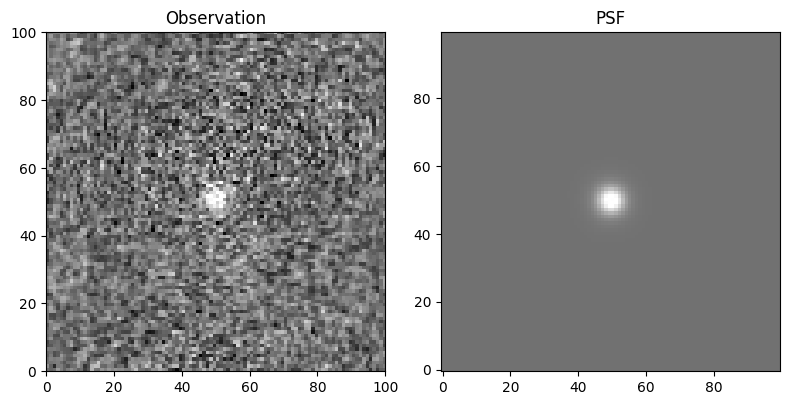

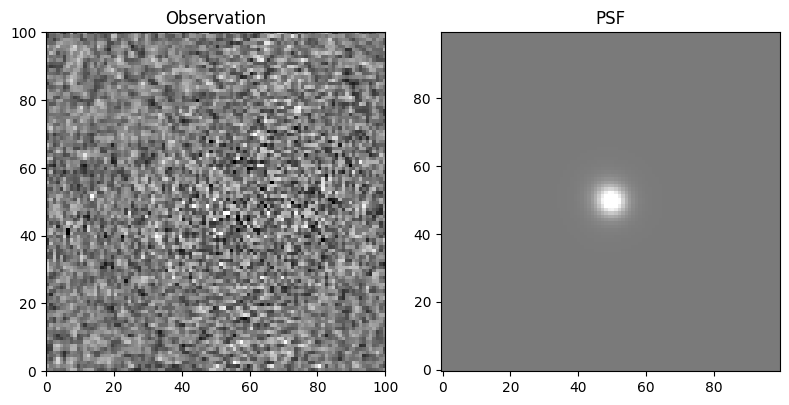

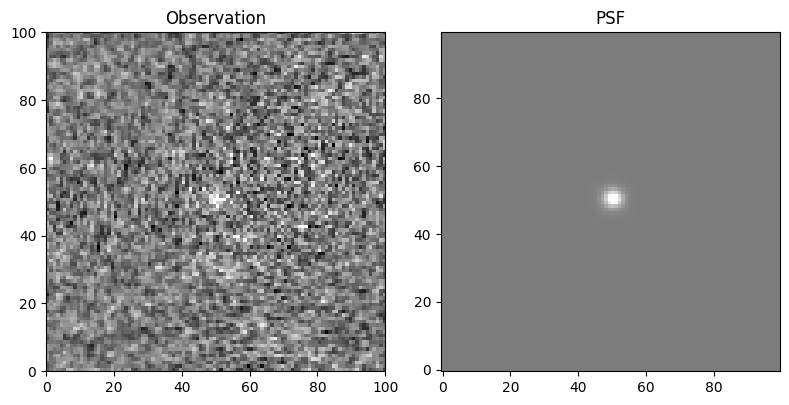

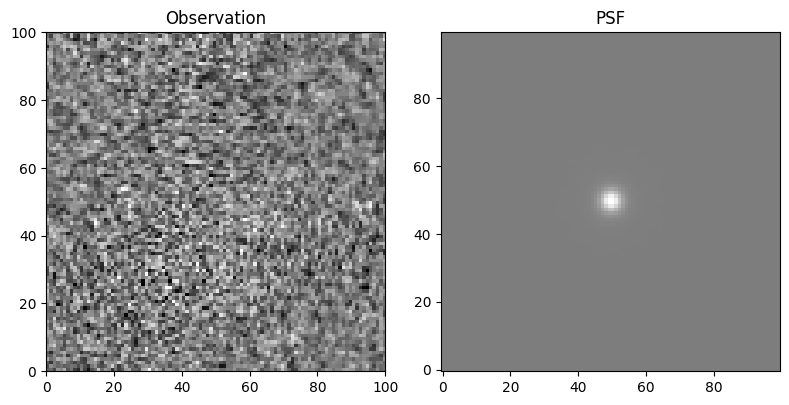

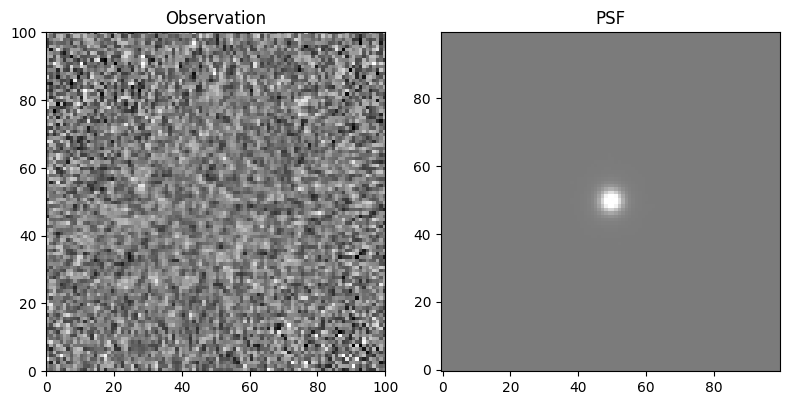

In [14]:
for ind,(obs, norm) in enumerate(zip(obssingle[5:10], normsingle[5:10])):
    scarlet.display.show_observation(obs, norm=norm, sky_coords=ra_dec, show_psf=True, add_labels=False)

In [15]:
model_psf_s = scarlet.GaussianPSF(sigma=0.9)
model_frame_s = scarlet.Frame.from_observations(obssingle, coverage='intersection',
                                                model_psf=model_psf_s)
print(model_frame_s)

In [15]:
sources = []
if len(ra_dec[0].shape)==1:
    print('Only one source found, initializing in center')
    for ind,sky_coord in enumerate([ra_dec[0]]):
        separ=[0]
        print('Initialization source',ind,'at',sky_coord)
        sources.append(scarlet.PointSource(model_frame_s,
                                sky_coord,
                                obssingle,
                                ))
        sources.append(scarlet.SingleExtendedSource(model_frame_s,
                            sky_coord,
                               obssingle,
                               thresh=0.01,
                               shifting=False,
                               resizing=False,
                               boxsize=50,                     
                              ))
        indtransient=0
else:
    c2 = [SkyCoord(ra*u.deg,dec*u.deg,frame='icrs') for ra,dec in ra_dec[0]]
    separ = [coord_transient.separation(c).arcsecond for c in c2]
    indtransient = np.argmin(separ)
    indgal = np.argmin(separ)
    for ind,sky_coord in enumerate(ra_dec[0]):
        print('Initialization source',ind,'at',sky_coord)
        if ind == indtransient:
            sources.append(scarlet.PointSource(model_frame_s,
                                    sky_coord,
                                    obssingle
                                    ))

            sources.append(scarlet.SingleExtendedSource(model_frame_s,
                                sky_coord,
                                   obssingle,
                                   thresh=0.01,
                                   shifting=False,
                                   resizing=True,
                                   boxsize=50,                     
                                  ))

        else:
            sources.append(scarlet.SingleExtendedSource(model_frame_s,
                                sky_coord,
                                   obssingle,
                                   thresh=0.01,
                                   shifting=False,
                                   resizing=False,
                                   boxsize=50,
                                  ))

Zero or negative spectrum [-11.251805] at [  8.94910849 -42.72465368]
Zero or negative spectrum [-239.21844] at [  8.94910849 -42.72465368]
Zero or negative spectrum [-957.687] at [  8.94910849 -42.72465368]
Zero or negative spectrum [-0.23150635] at [  8.94910849 -42.72465368]
Zero or negative spectrum [-4.0110474] at [  8.94910849 -42.72465368]
Zero or negative spectrum [-29.957031] at [  8.94910849 -42.72465368]


Only one source found, initializing in center
Initialization source 0 at [  8.94910849 -42.72465368]


In [16]:
epochs = np.asarray([obs.channels[0][0] for obs in obssingle])
bands0,inds0 = np.unique([obs.channels[0][0] for obs in obssingle],return_index=True)

bands = epochs[inds0]
repeats = np.asarray([np.sum([epochs==b]) for b in bands],dtype=int)    
scarlet.initialization.set_spectra_to_match(sources, obssingle)#, repeats=repeats)

['g0']
['r1']
['r2']
['g3']
['i4']


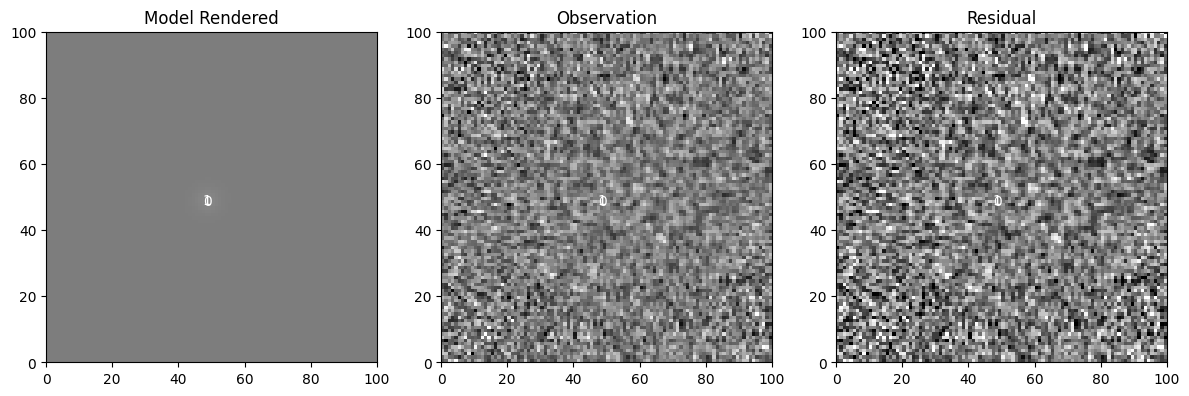

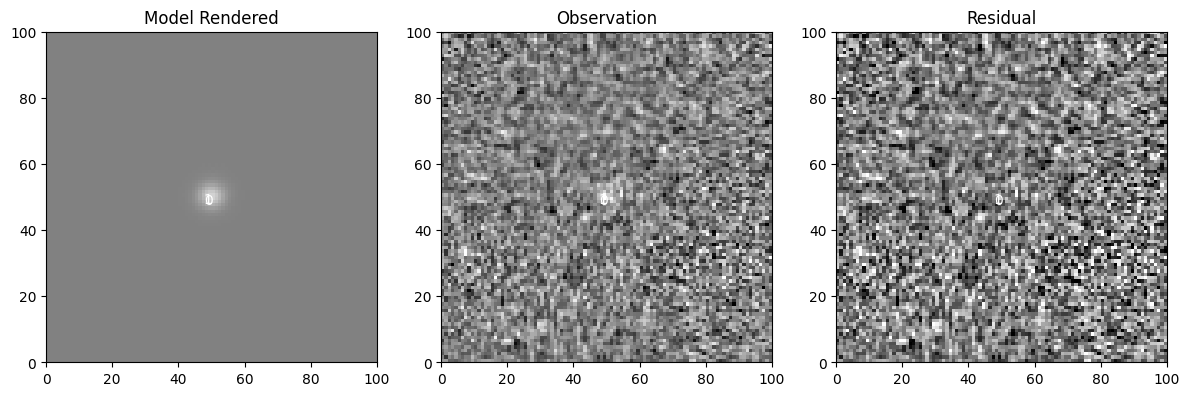

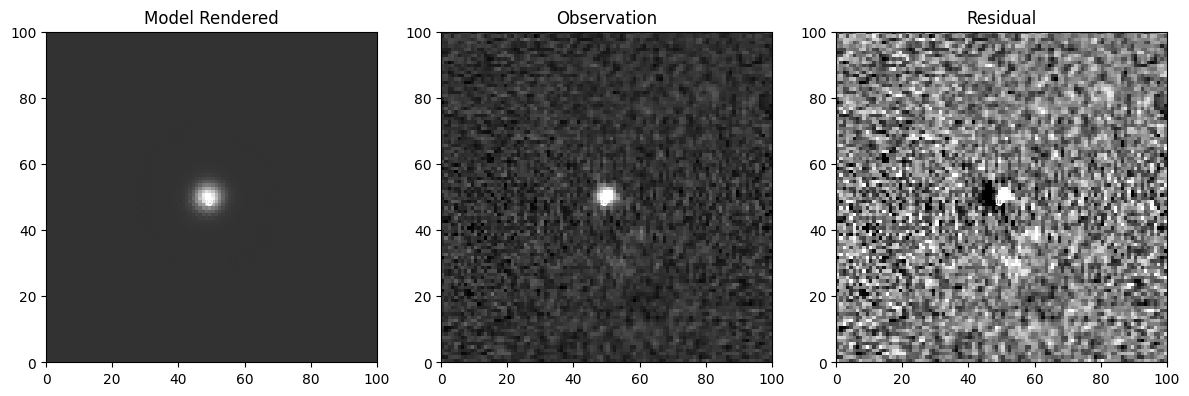

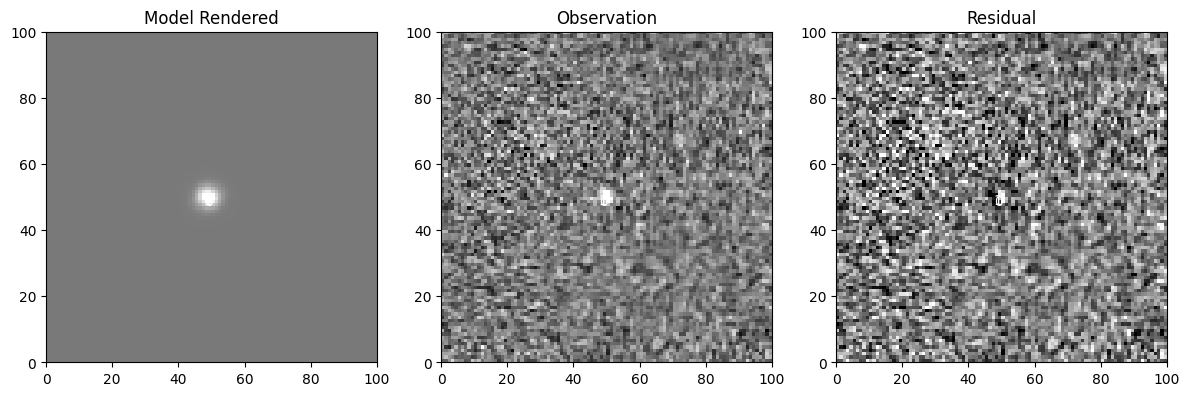

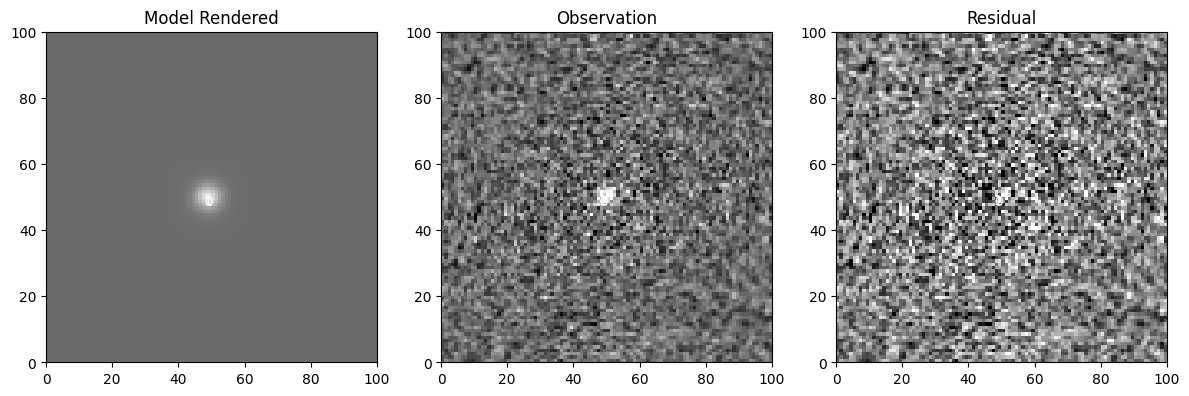

In [17]:
blend = scarlet.Blend(sources, obssingle)

for i in range(len(obssingle[:5])):
    print(obssingle[i].channels)
    scarlet.display.show_scene(sources,
                               norm=normsingle[i],
                               observation=obssingle[i],
                                show_model=False,
                               show_rendered=True,
                               show_observed=True,
                               show_residual=True,
                               figsize=(12,4)
                              )

scarlet ran for 12 iterations to logL = -381300.09641338204


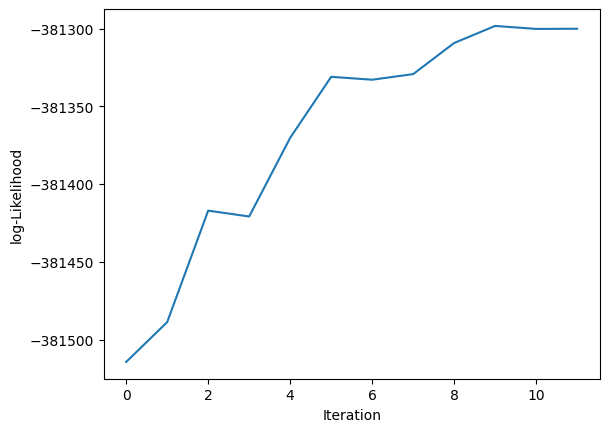

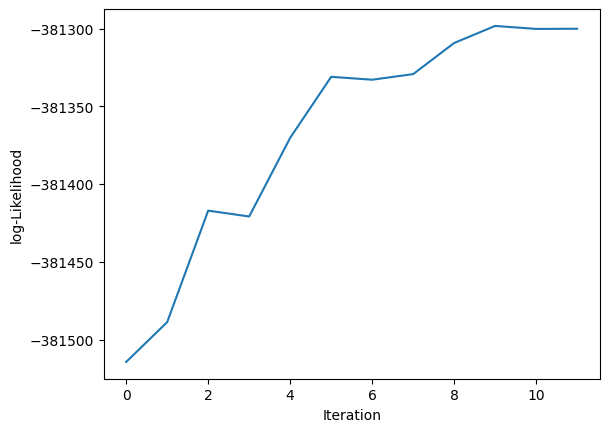

In [18]:
it, logL = blend.fit(200, e_rel=1e-6)
print(f"scarlet ran for {it} iterations to logL = {logL}")
scarlet.display.show_likelihood(blend)

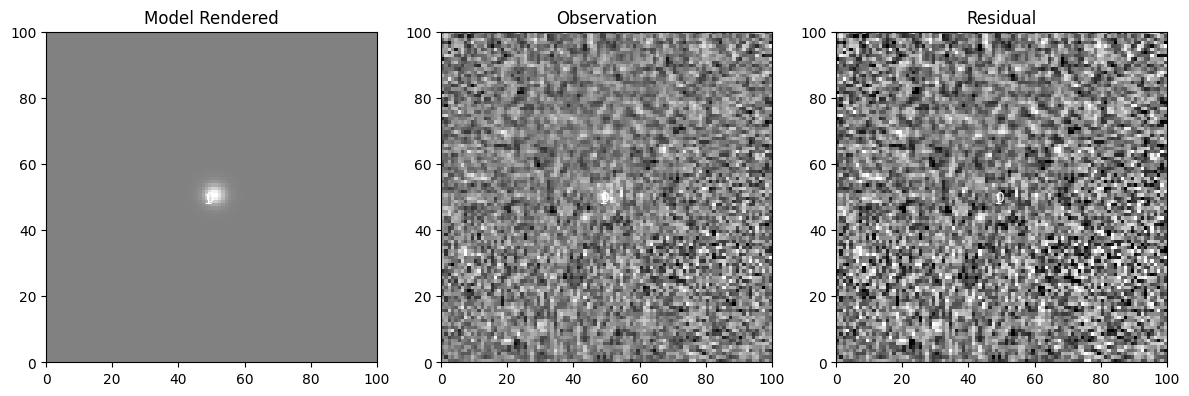

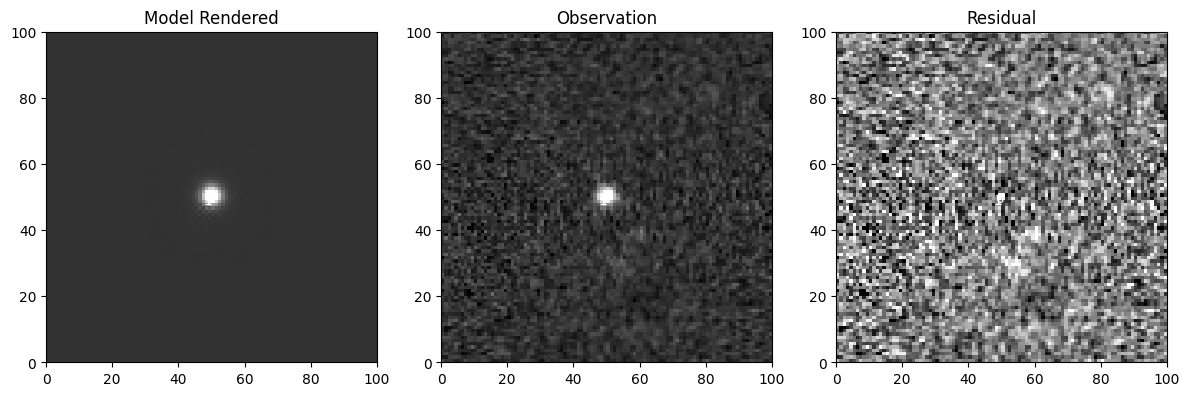

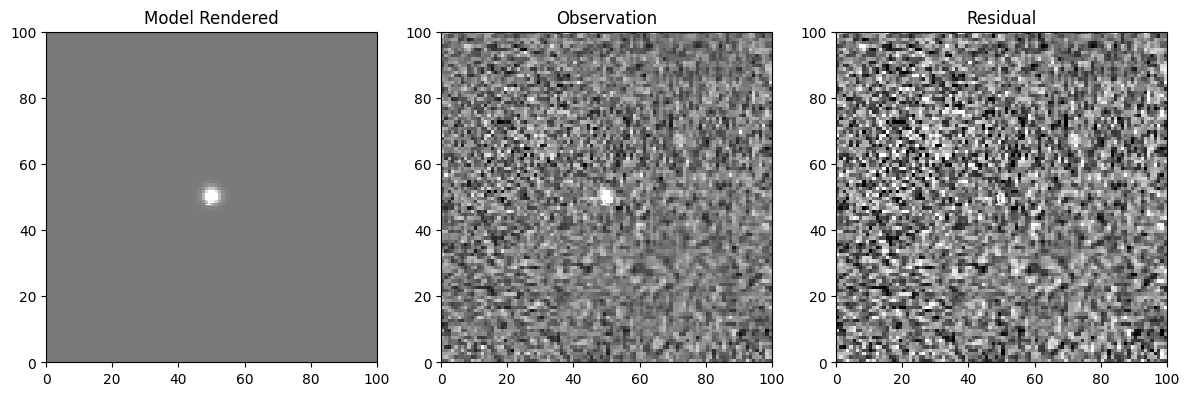

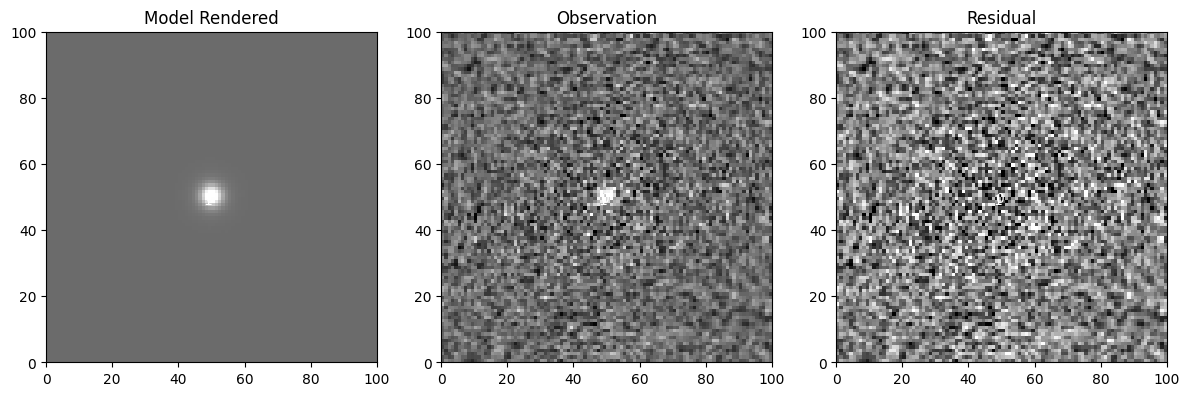

In [19]:
for i in range(5):#len(obssingle)):
    scarlet.display.show_scene(sources,
                               norm=normsingle[i],
                               observation=obssingle[i],
                               show_model=False,
                               show_rendered=True,
                               show_observed=True,
                               show_residual=True,
                               figsize=(12,4)
                              )

### Scarlet 2

In [30]:
frame_psf_sc2 = scarlet2.GaussianPSF(0.9)
model_frame_sc2 = scarlet2.Frame(scarlet2.Box((len(observations_sc2),
                                               observations_sc2[0].data.shape[-2],
                                               observations_sc2[0].data.shape[-1])), 
                                 psf=frame_psf_sc2, 
                                 channels=channels_sc2, 
                                 wcs=obssingle[0].wcs)

box_sizes = [s.morphology.bbox.shape for s in sources]
for obs in observations_sc2:
    obs.match(model_frame_sc2)

In [31]:
morph_init = [None]*(len(sources))
for i,s in enumerate(sources):
    raw = s.morphology.get_model()
    morph_init[i] = (raw-jnp.min(raw))/(jnp.max(raw)-jnp.min(raw))+1e-10

In [34]:
from galaxygrad import ZTF_ScoreNet64
prior_model = ZTF_ScoreNet64

bandall = ['g', 'r', 'i']
# define and data transforms applied to the training data
# transform to training space
# these will be applied to the data before training
# and accounted for in the gradient (i.e. the jacobian is applied)
def transform(x):
    sigma_y = 0.10
    return jnp.log(x + 1) / sigma_y
stepnum=500
from scarlet2 import nn
with scarlet2.Scene(model_frame_sc2) as scene:
    for i,src in enumerate(sources):      
        prior = nn.ScorePrior(model=prior_model) 
        # prior on galaxy morphology
        if i==indtransient:
            bboxpos = src.morphology.bbox.center
            diff = src.center - list(bboxpos)[1:2]
            pos = np.asfarray([src.center[0]-2,src.center[1]-2])
            flux = src.spectrum.get_model()
            flux[flux<0.1*np.median(flux)] = np.median(flux)
            n_steps, peak_value2 = stepnum, jnp.max(flux[~np.isinf(flux)])
            print(peak_value2)
            schedule3 = optax.cosine_onecycle_schedule(n_steps, peak_value2, final_div_factor=1)
            AGN_step = lambda p: scarlet2.relative_step(p, factor=1e-3)
            scarlet2.PointSource(
                    pos,
                    scarlet2.ArraySpectrum(Parameter(jnp.asarray(flux), 
                                                     stepsize=AGN_step, 
                                                     constraint=constraints.positive)) 
                #,constraint = scarlet2.PositiveConstraint())
                )
            
        else:
            pos = np.asfarray([src.morphology.bbox.center[0]-2,
                               src.morphology.bbox.center[1]-2])
            flux = src.spectrum.get_model()[inds0]
            n_steps, peak_value = stepnum, 1#jnp.max(flux)
            schedule = optax.cosine_onecycle_schedule(n_steps, peak_value, final_div_factor=1)
            morph_step = lambda p: scarlet2.relative_step(p, factor=1e-3)
            #lambda p, it: scarlet2.relative_step(p, factor=2e-3) * schedule(it)
            test_step_morph =2e-3*peak_value
            n_steps, peak_value2 = stepnum, 0.1*jnp.max(flux[~np.isinf(flux)])
            print(peak_value2)
            schedule2 = optax.cosine_onecycle_schedule(n_steps, peak_value2, final_div_factor=1)
            gal_step = lambda p: scarlet2.relative_step(p, factor=1e-3)
            scarlet2.Source(
                pos,
                scarlet2.StaticArraySpectrum(Parameter(jnp.asarray(flux), 
                                                       stepsize=gal_step,
                                                       constraint = constraints.positive),
                                             filters=bandall),
                scarlet2.ArrayMorphology(Parameter(morph_init[i], 
                                                   stepsize=morph_step, 
                                                   constraint = constraints.positive, 
                                                   prior=prior)))

135.2214
23.884842


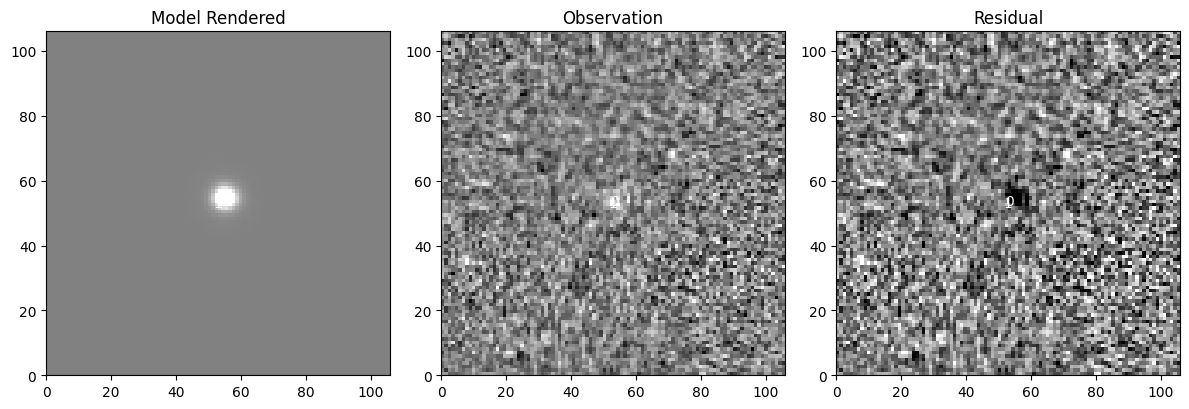

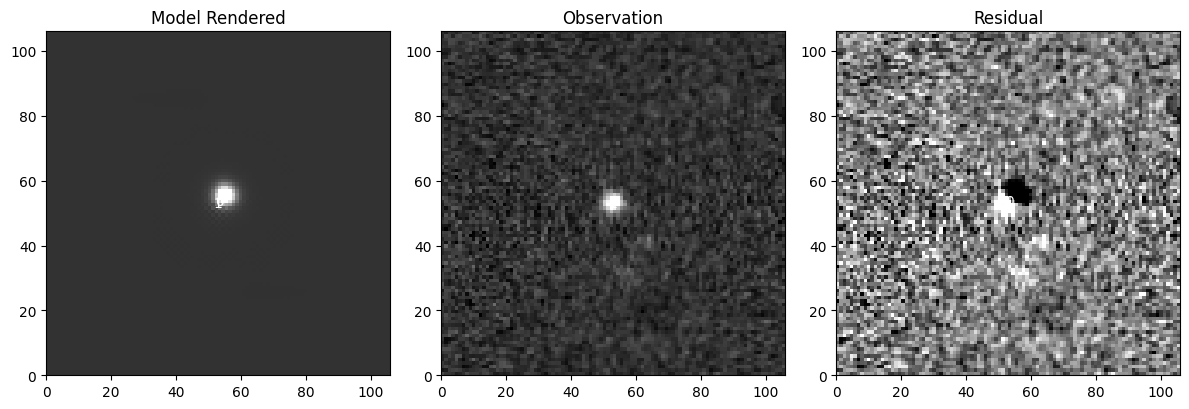

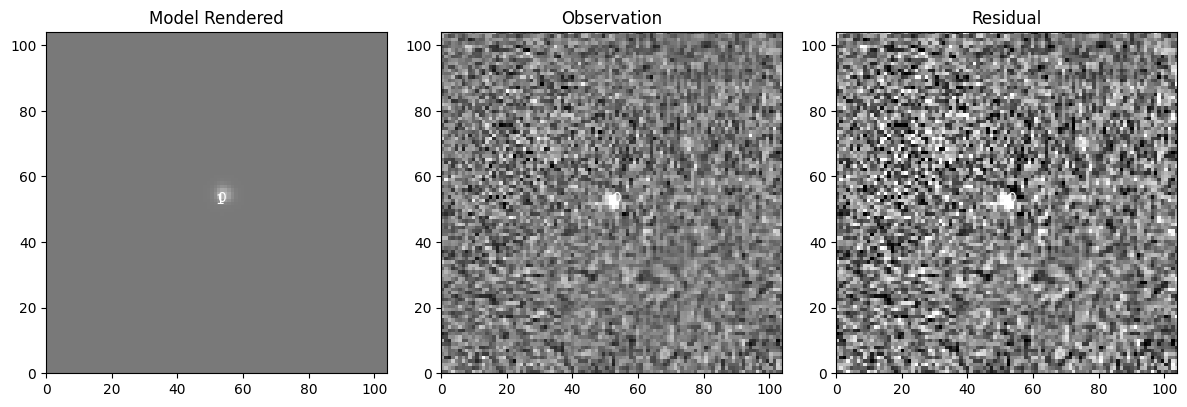

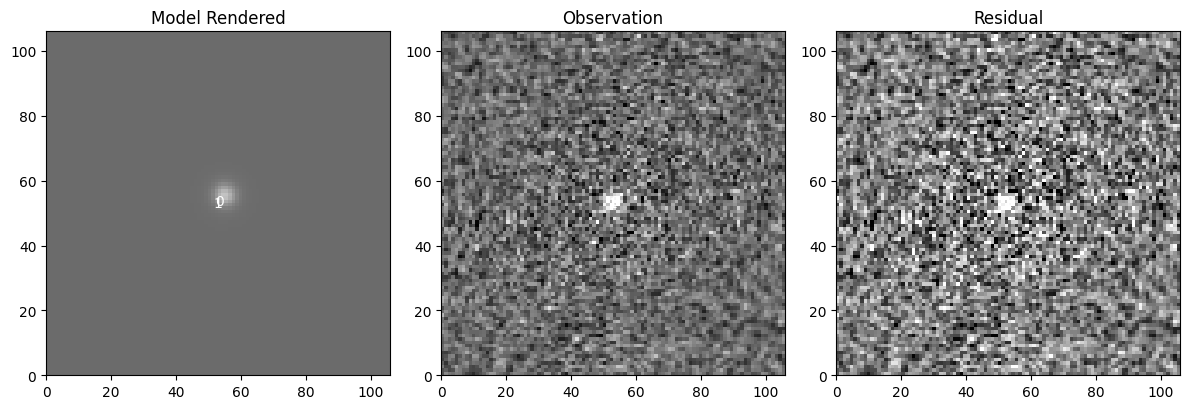

In [ ]:
for i,(chan,obs,obs1,norm) in enumerate(zip(np.asarray(channels)[:5],np.asarray(observations_sc2)[:5],
                                            np.asarray(obssingle)[:5],np.asarray(normsingle)[:5])):
        model_ = obs.render(scene())
        scarlet.display.show_scarlet2_scene(sources,
                           norm=norm,
                           observation=obs,
                           #channel_map = obs.renderer.channel_map,
                           model = model_,
                           frame = scarlet.Frame.from_observations(obs1, 
                                                                   coverage='intersection', 
                                                                   model_psf=model_psf_s),#model_frame_s,
                           show_rendered=True,
                           show_observed=True,
                           show_residual=True,
                           figsize=(12,4)
                          )

In [36]:
#Free up the AGN position parameter so that it can be refitted
n_steps, peak_value_pos = stepnum, 1
schedulepos = optax.cosine_onecycle_schedule(n_steps, peak_value_pos, final_div_factor=1)
pos_step = lambda p: scarlet2.relative_step(p, factor=.1)
flux = scene.sources[indtransient].spectrum.data
scene.set_info('sources.'+str(indtransient)+'.morphology.center', fixed=False,stepsize = pos_step)
#Fit the scene
scene_ = scene.fit(observations_sc2, max_iter=stepnum, e_rel=1e-6, schedule=schedulepos)

100%|██████████| 500/500 [1:01:15<00:00,  7.35s/it, loss=114361.98, max_change=0.000282]


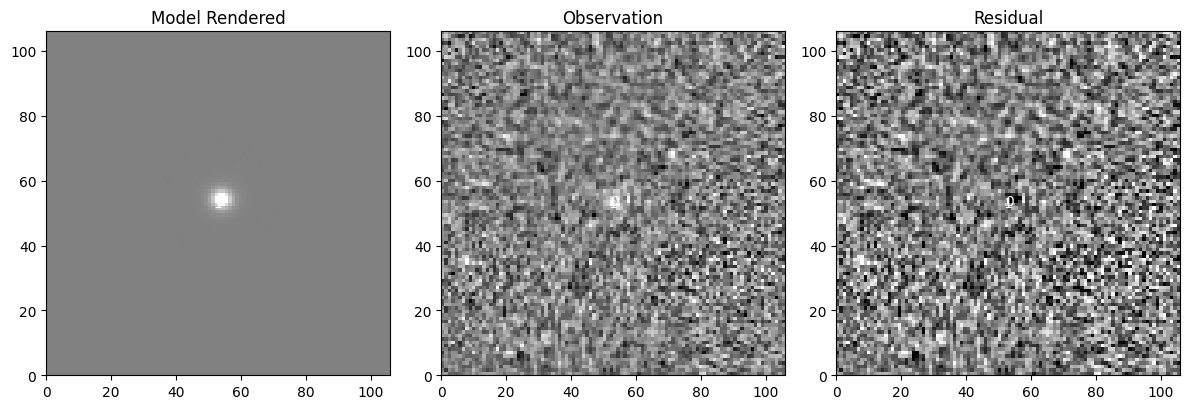

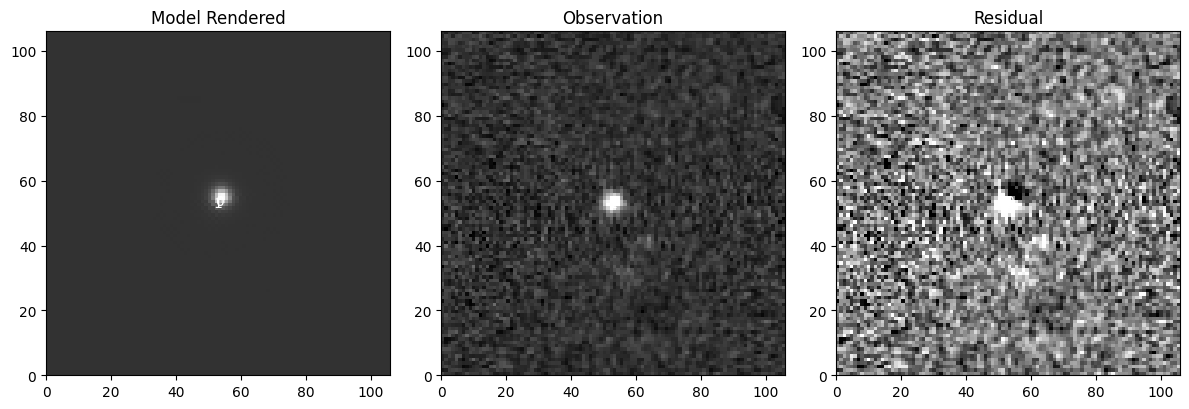

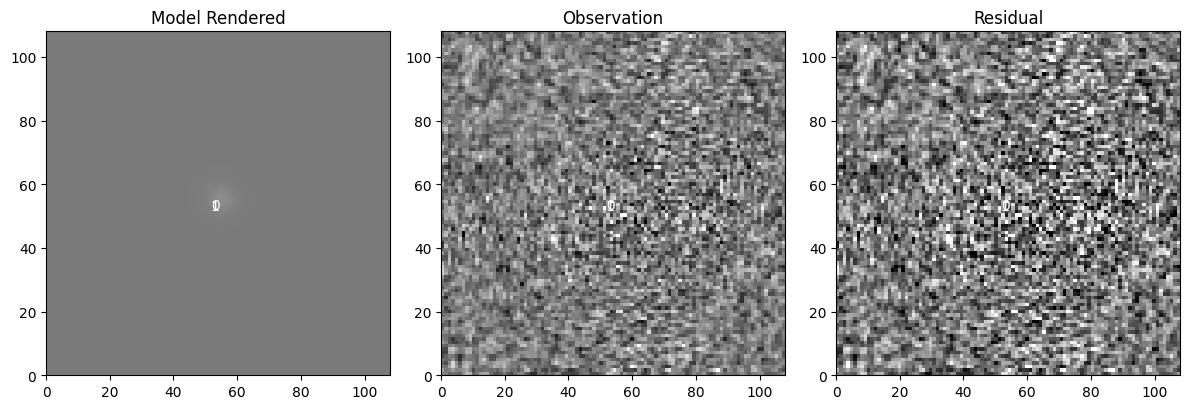

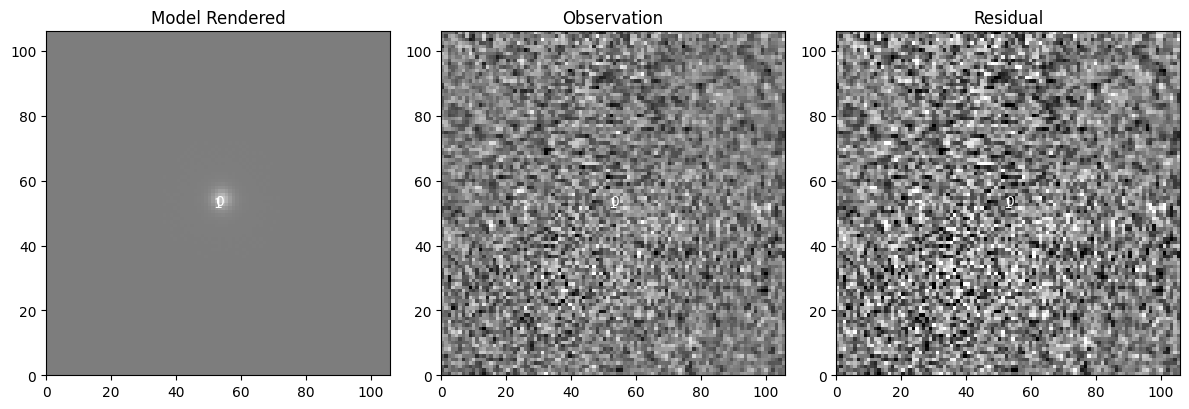

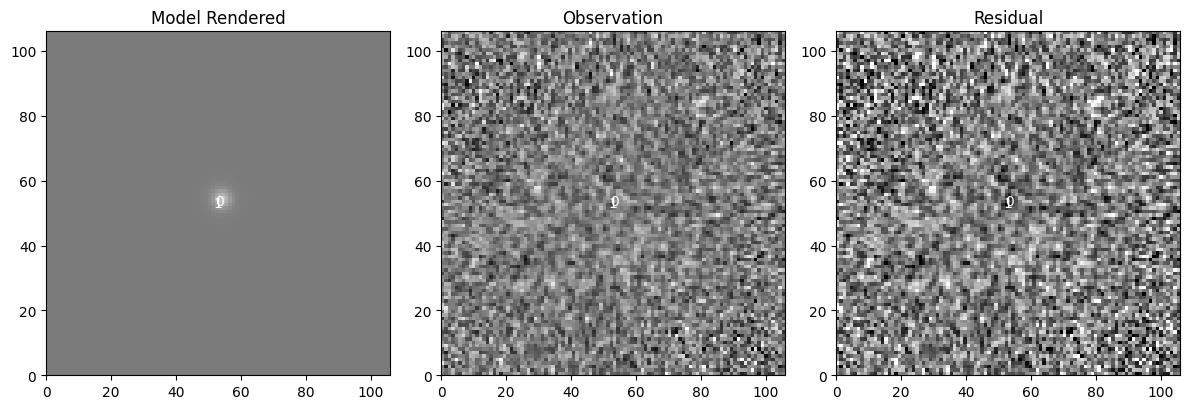

In [38]:
#Plot the models and residuals for the first 10 images
resid_wt = []
for i,(chan,obs,obs1,norm,clipwt) in enumerate(zip(channels[:10],
                                                     observations_sc2[:10],
                                                     obssingle,
                                                     normsingle[:10],
                                                     clipwts[:10]
                                                    )):
        model_ = obs.render(scene_())
        resid_wt.append((obs.data - model_)*np.sqrt(clipwt.data))
        scarlet.display.show_scarlet2_scene(sources,
                           norm=norm,
                           observation=obs,
                           #channel_map = obs.renderer.channel_map,
                           model = model_,
                           frame = scarlet.Frame.from_observations(obs1, 
                                                                   coverage='intersection', 
                                                                   model_psf=model_psf_s),#model_frame_s,
                           show_rendered=True,
                           show_observed=True,
                           show_residual=True,
                           figsize=(12,4)
                          )

/tmp/ipykernel_569925/1571555195.py:11: RuntimeWarning: divide by zero encountered in log
  ax.imshow(np.log(y), cmap = cmap,interpolation=int_method,
/tmp/ipykernel_569925/1571555195.py:12: RuntimeWarning: divide by zero encountered in log
  vmin = np.max([np.min(np.log(y)[np.log(y)>-15]),-15]))


ValueError: zero-size array to reduction operation minimum which has no identity

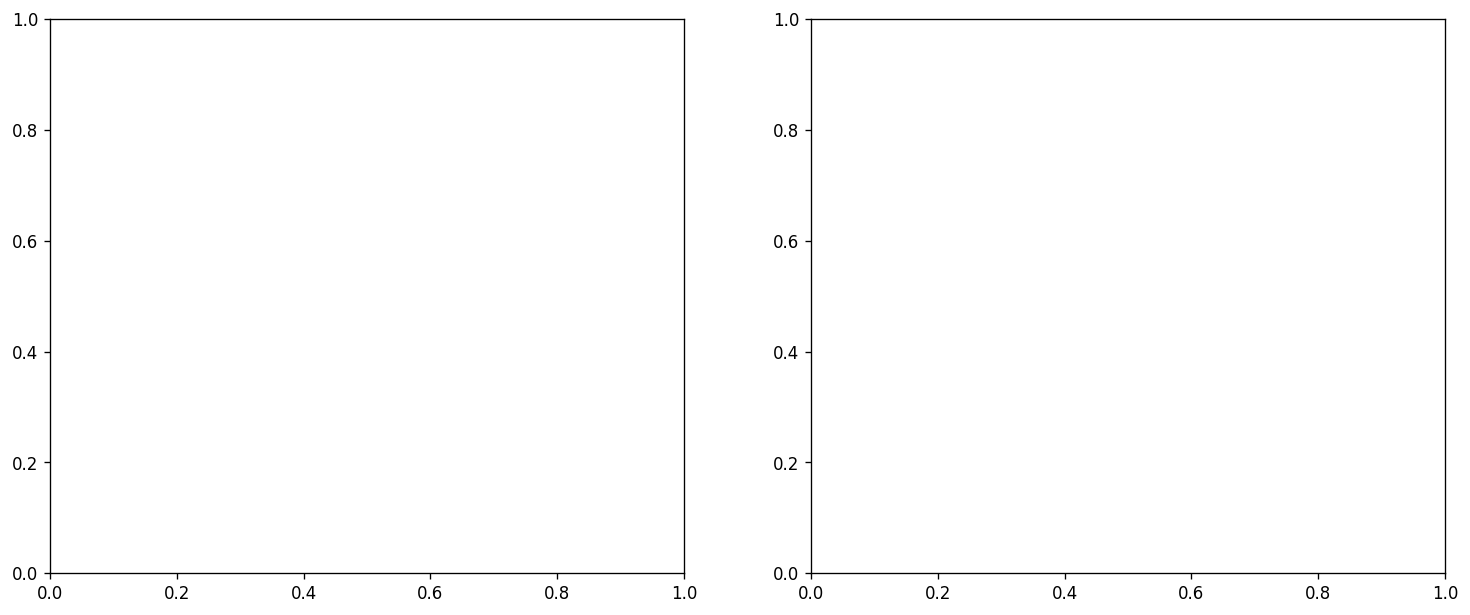

In [39]:
#Show the point source and host galaxy models
import cmasher as cmr
cmap = cmr.lilac
int_method='none'
fig, axes = plt.subplots(1, len( scene.sources ), figsize=(15,6),dpi=120)
for i, ax in enumerate(axes):
    if i==indtransient:
        y = scene_.sources[i].morphology()
    else:
        y = scene_.sources[i].morphology.data
    ax.imshow(np.log(y), cmap = cmap,interpolation=int_method,
              vmin = np.max([np.min(np.log(y)[np.log(y)>-15]),-15]))
    ax.set_title(f"source {i}", fontsize = 18)
    ax.invert_yaxis()
plt.suptitle('reconstructed sources (transient = '+str(indtransient)+')', fontsize=12)#,y=0.75)
# plt.savefig(plotdir+'/'+srcname+'_reconstructed_sources.png')
plt.show()
plt.clf()

In [ ]:
phot = db.Photometry.get_for_obj('DC21cozcn')
phot_data = {}
zp0 = {'g': 28.703, 'r': 30.069, 'i': 31.127}
for i in range(len(phot)):
    phot_band = phot[i][1]
    phot_data[i] = pd.DataFrame()
    phot_data[i]['mjd'] = [x.mjd for x in phot_band]
    phot_data[i]['fluxerr'] = [0 for x in phot_band] # CHANGE
    fluxes = []
    for x in phot_band:
        newflux = x.flux*10**((phot_band[0].magzp-x.magzp)/2.5)
        fluxes.append(newflux)
    phot_data[i]['flux'] = fluxes
# phot_data

In [ ]:
fig, axes = plt.subplots(3,1, figsize=[10,18])

indgal=indtransient+1
zps = np.asfarray(zps)
flux = scene_.sources[indtransient].spectrum.data * np.sum(scene_.sources[indtransient].morphology(),
                                                           axis=(-2,-1)) 
fluxgal = scene_.sources[indgal].spectrum.data * np.sum(scene_.sources[indgal].morphology(),axis=(-2,-1)) 
times=np.asfarray(times)
for bind,(b,c) in enumerate(zip(['g','r','i'],['green','red','orange'])):
        fluxes = flux[epochs==b]
        fluxes = [fluxes[i] * 10**((zp0[b]-zps[i])/2.5) for i in range(len(fluxes))]
        axes[bind].scatter(times[epochs==b],fluxes,
                    label=b,color=c,marker='.')
        # testdata = pd.DataFrame({'mjd': times[epochs==b], 'flux': flux[epochs==b]})
        # testdata.to_csv(f"{data_dir}/{obj_name}_{b}band.dat", index=False)
        # axes[bind].scatter(phot_data[bind].mjd, phot_data[bind].flux, color='b', 
        #                    label='Ap Phot', marker='.')
        # axes[bind].invert_yaxis()
        axes[bind].set_xlim([59450, 59600])
        # axes[bind].set_ylim([-500, 2500])
        axes[bind].plot([59450, 59600], [0, 0], 'r--')
        axes[bind].set_ylabel(f"{b.upper()}-band Flux", fontsize=16)
        axes[bind].set_xlabel("MJD", fontsize=16)
# plt.xlabel('MJD-57700')
# plt.suptitle(f"{obj_name} light curves", fontsize=20)
plt.tight_layout()
plt.legend()
plt.savefig(f"figs/{obj_name}_lc_sample.png", bbox_inches='tight')
plt.show()

In [ ]:
scene_.set_info(scene_.parameters.keys(), fixed=True) 
scene_.set_info('sources.'+str(indtransient)+'.spectrum.data', fixed=False, 
                # can set this to true, with galaxy morphology
                prior=dist.Normal(scene_.sources[indtransient].spectrum.data, 
                                  0.5*scene_.sources[indtransient].spectrum.data))
#prior=dist.Uniform(scene_.sources[0].spectrum.data-2.5,scene_.sources[0].spectrum.data+2.5))
##01scene.sources[5].spectrum.data))#dist.Uniform(
#scene_.sources[5].spectrum.data-2,scene_.sources[5].spectrum.data+2)) 
mcmc = scene_.sample(observations_sc2,num_warmup=100, num_samples=1000) 
q = mcmc.get_samples()['sources.'+str(indtransient)+'.spectrum.data'] 
q1 = np.percentile(q,[2.5,16,50,84,97.5],axis=0) 
fac = np.sum(scene_.sources[indtransient].morphology(),axis=(-2,-1))
fluxes = [] 
fluxerrors = [] 
for i in range(q1.shape[1]): 
    print(i,'median = ',q1[2][i],'std = ',(q1[3][i]-q1[1][i])/2) 
    fluxes.append(q1[2][i]*fac) 
    fluxerrors.append((q1[3][i]-q1[1][i])/2*fac)

mcmc.print_summary() 
#Uncomment this to show the corner plot
#corner.corner(mcmc).show() 
#plt.savefig(plotdir+'/'+srcname+'_transientflux_corner.png')
#plt.show()
#plt.clf()
zps = np.asfarray(zps)
fluxes = np.asfarray(fluxes)
fluxerrors = np.asfarray(fluxerrors)
times=np.asfarray(times)
# print(times,epochs,flux,fluxerrors)


fac = np.sum(scene_.sources[indtransient].morphology(),axis=(-2,-1))

# plt.savefig(plotdir+'/'+srcname+'_lc_flux.png')
# plt.show()
# plt.clf()
# outlchead=['MJD','FLUX','FLUXERR','BAND']
# outlc=np.column_stack((times,fluxes,fluxerrors,epochs))
# outlc = np.vstack((outlchead,outlc))
# np.savetxt(plotdir+'/lc.txt',np.asarray(outlc,dtype=str),fmt='%s')
# sed=[]
# sederr=[]
# for b,c in zip(bandall,['green','orange','red','purple','blue']):
#     sed.append(np.mean(fluxes[epochs==b]))
#     sederr.append(np.std(fluxes[epochs==b]))
#     plt.errorbar(times[epochs==b]-57700,25-2.5*np.log10(fluxes[epochs==b]),
#                  yerr = 1.0857*fluxerrors[epochs==b]/fluxes[epochs==b],
#                  linestyle='',label=b,color=c,marker='.')#+fluxgal[epochs==b]),label=b,color=c,marker='.')
# plt.xlabel('MJD-57700')
# plt.ylabel('Magnitude')
# plt.gca().invert_yaxis()
# plt.legend()
# plt.savefig(plotdir+'/'+srcname+'_lc_mag.png')
# plt.show()

sample:  40%|████      | 442/1100 [18:20:13<6:54:19, 37.78s/it, 7 steps of size 6.40e-01. acc. prob=0.91]     

In [ ]:
fig, axes = plt.subplots(3,1,figsize=[10,15])

for bind,(b,c) in enumerate(zip(bandall,['green','red','orange'])):
    axes[bind].errorbar(times[epochs==b],fluxes[epochs==b],
                        yerr = fluxerrors[epochs==b],linestyle='',label=b,
                        color=c,marker='.')#+fluxgal[epochs==b]),label=b,color=c,marker='.')
    axes[bind].set_xlim([59450, 59600])
    axes[bind].set_xlabel('MJD')
    axes[bind].set_ylabel('Flux')
    axes[bind].legend()
plt.title(obj_name)

In [ ]:
fig, axes = plt.subplots(3, 1, figsize=[10,15])

for bind,(b,c) in enumerate(zip(bandall,['green','red','orange'])):
    axes[bind].errorbar(times[epochs==b],fluxes[epochs==b],
                 yerr = fluxerrors[epochs==b],linestyle='',
                 capsize=5,label=b,color=c,marker='.')
    axes[bind].set_xlim([59450, 59600])
    axes[bind].set_xlabel('MJD')
    axes[bind].set_ylabel('Flux')
    axes[bind].legend()
plt.title(f"{obj_name} light curves")
# plt.savefig(plotdir+'/'+srcname+'_lc_flux.png')
plt.show()
plt.clf()
# Make sure the prior makes sense given original flux